# Classification of 100 species of butterflies/moths
Alberto Mosconi [student id: 898685]

final project for the course
**Advanced Computational Techniques for Big Imaging and Signal Data**

Artificial Intelligence for Science and Technology, University of Milano-Bicocca, A.Y. 2022/23

# initial setup

the following commented lines are useful when running the code on Google Colab.

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

In [2]:
# import os
# os.environ['KAGGLE_USERNAME'] = ""
# os.environ['KAGGLE_KEY'] = ""

In [3]:
# !kaggle datasets download -d gpiosenka/butterfly-images40-species
# !unzip -q -n butterfly-images40-species.zip -d data
# !rm butterfly-images40-species.zip

In [4]:
# !kaggle datasets download -d hammaadali/insects-recognition
# !unzip -q -n insects-recognition.zip -d data
# !rm insects-recognition.zip
# !rm -rf data/Butterfly/

In [5]:
# !kaggle datasets download -d alexo98/leaf-detection
# !unzip -q -n leaf-detection.zip -d data/leaves
# !rm leaf-detection.zip

install some of the dependecies required to run this project.

In [6]:
# !pip install torchmetrics -q

import all the libraries used in the code.

In [1]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision import transforms, models
import torchmetrics as tm
from typing import Tuple, List, Any
from tqdm import tqdm
from datetime import datetime

# dataset

the main dataset for this project is hosted on kaggle at [gpiosenka/butterfly-images40-species](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species).

read the `csv` file containing all filenames and corresponding labels and convert it into a pandas DataFrame.

In [2]:
df_butterflies = pd.read_csv('data/butterflies and moths.csv')
df_butterflies

class id                    filepaths           labels data set
0             0         train/ADONIS/001.jpg           ADONIS    train
1             0         train/ADONIS/002.jpg           ADONIS    train
2             0         train/ADONIS/003.jpg           ADONIS    train
3             0         train/ADONIS/004.jpg           ADONIS    train
4             0         train/ADONIS/005.jpg           ADONIS    train
...         ...                          ...              ...      ...
13589        99  valid/ZEBRA LONG WING/1.jpg  ZEBRA LONG WING    valid
13590        99  valid/ZEBRA LONG WING/2.jpg  ZEBRA LONG WING    valid
13591        99  valid/ZEBRA LONG WING/3.jpg  ZEBRA LONG WING    valid
13592        99  valid/ZEBRA LONG WING/4.jpg  ZEBRA LONG WING    valid
13593        99  valid/ZEBRA LONG WING/5.jpg  ZEBRA LONG WING    valid

[13594 rows x 4 columns]

the dataset is already split into train, validation and testing partitions however this subdivision is overritten to have more control, therefore the `data set` column is dropped.

In [3]:
df_butterflies = df_butterflies.drop('data set', axis=1)

by plotting a histogram of the class distribution we can see that it is fairly balanced.

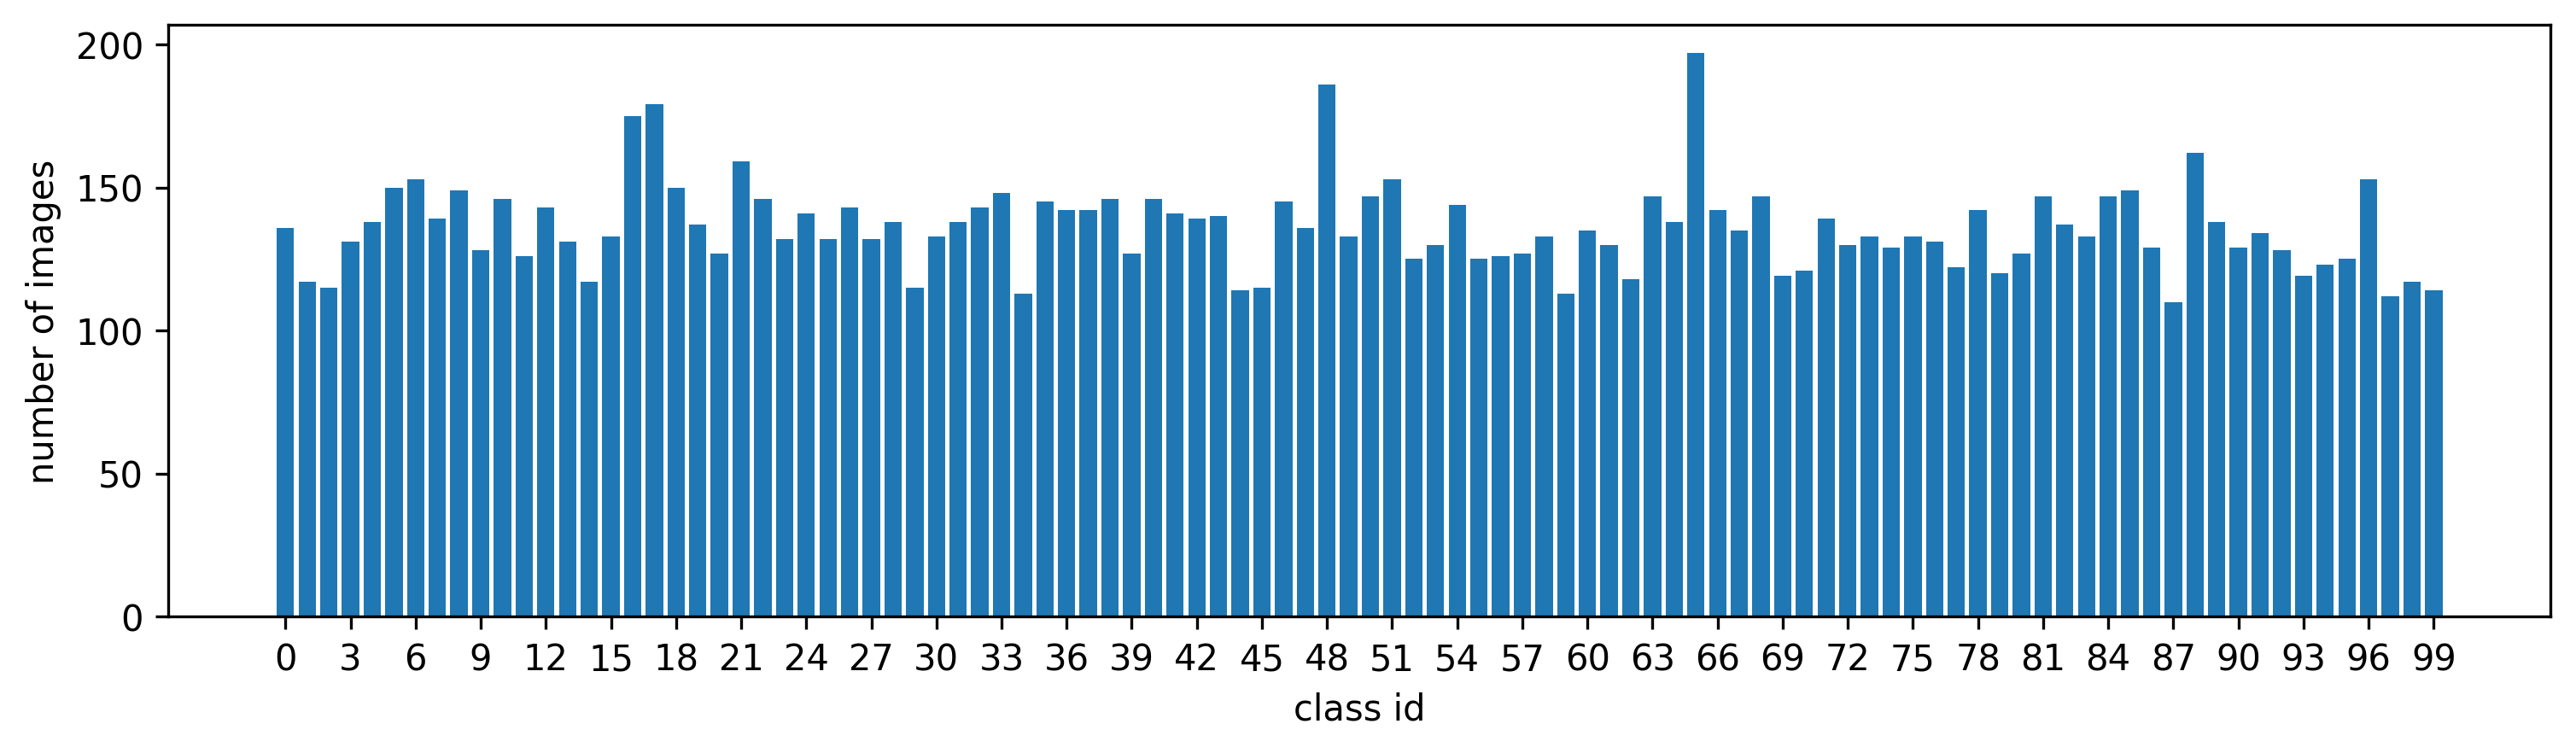

In [46]:
plt.figure(figsize=(12, 3), dpi=300)
bars = df_butterflies.groupby('class id').count()['labels'].tolist()
plt.bar(range(0, 100), bars)
plt.xticks(np.arange(0, 100, 3))
plt.xlabel('class id')
plt.ylabel('number of images')
plt.grid(False)
plt.show()

the main issue that affects the complete-ness of the model as a deployed product in mind the lack of a class without any butterfly/moth.

a new dataset of images is merged to compensate, making sure the number of samples is consistent with the other classes.

more specifically 180 images are chosen in the following way, and are assigned the label `OTHER` (id 100):
- 25 mosquitoes
- 25 ladybirds
- 25 grasshoppers
- 25 dragonflies
- 80 just leaves, no insects

In [36]:
df_other = pd.DataFrame(columns=['filepaths', 'class id', 'labels'])

for dir in ['Mosquito', 'Ladybird', 'Grasshopper', 'Dragonfly']:
  images = random.sample(os.listdir(f'data/{dir}'), 25)
  for image in images:
    df_other.loc[len(df_other)] = [f'{dir}/{image}', 100, 'OTHER']

df_other

filepaths  class id labels
0         Mosquito/google138.jpg       100  OTHER
1         Mosquito/google628.jpg       100  OTHER
2    Mosquito/istockphoto300.jpg       100  OTHER
3    Mosquito/istockphoto433.jpg       100  OTHER
4         Mosquito/google216.jpg       100  OTHER
..                           ...       ...    ...
95  Dragonfly/istockphoto125.jpg       100  OTHER
96         Dragonfly/google7.jpg       100  OTHER
97       Dragonfly/google312.jpg       100  OTHER
98  Dragonfly/istockphoto111.jpg       100  OTHER
99       Dragonfly/google187.jpg       100  OTHER

[100 rows x 3 columns]

In [37]:
df_leaves = pd.read_csv('data/leaves/train.csv').sample(80)
df_leaves = df_leaves.reset_index(drop=True)
df_leaves['filepaths'] = 'leaves/train/' + df_leaves['image_id']
df_leaves = df_leaves.drop(['width', 'height', 'bbox', 'image_id'], axis=1)
df_leaves['class id'] = 100
df_leaves['labels'] = 'OTHER'

df_leaves

filepaths  class id labels
0   leaves/train/LEAF_1142.jpg       100  OTHER
1   leaves/train/LEAF_0692.jpg       100  OTHER
2   leaves/train/LEAF_1054.jpg       100  OTHER
3   leaves/train/LEAF_0444.jpg       100  OTHER
4   leaves/train/LEAF_0713.jpg       100  OTHER
..                         ...       ...    ...
75  leaves/train/LEAF_0694.jpg       100  OTHER
76  leaves/train/LEAF_0982.jpg       100  OTHER
77  leaves/train/LEAF_1136.jpg       100  OTHER
78  leaves/train/LEAF_0104.jpg       100  OTHER
79  leaves/train/LEAF_0877.jpg       100  OTHER

[80 rows x 3 columns]

In [38]:
df_full = pd.concat([df_butterflies, df_other, df_leaves], axis=0)
df_full

class id                   filepaths  labels
0          0        train/ADONIS/001.jpg  ADONIS
1          0        train/ADONIS/002.jpg  ADONIS
2          0        train/ADONIS/003.jpg  ADONIS
3          0        train/ADONIS/004.jpg  ADONIS
4          0        train/ADONIS/005.jpg  ADONIS
..       ...                         ...     ...
75       100  leaves/train/LEAF_0694.jpg   OTHER
76       100  leaves/train/LEAF_0982.jpg   OTHER
77       100  leaves/train/LEAF_1136.jpg   OTHER
78       100  leaves/train/LEAF_0104.jpg   OTHER
79       100  leaves/train/LEAF_0877.jpg   OTHER

[13774 rows x 3 columns]

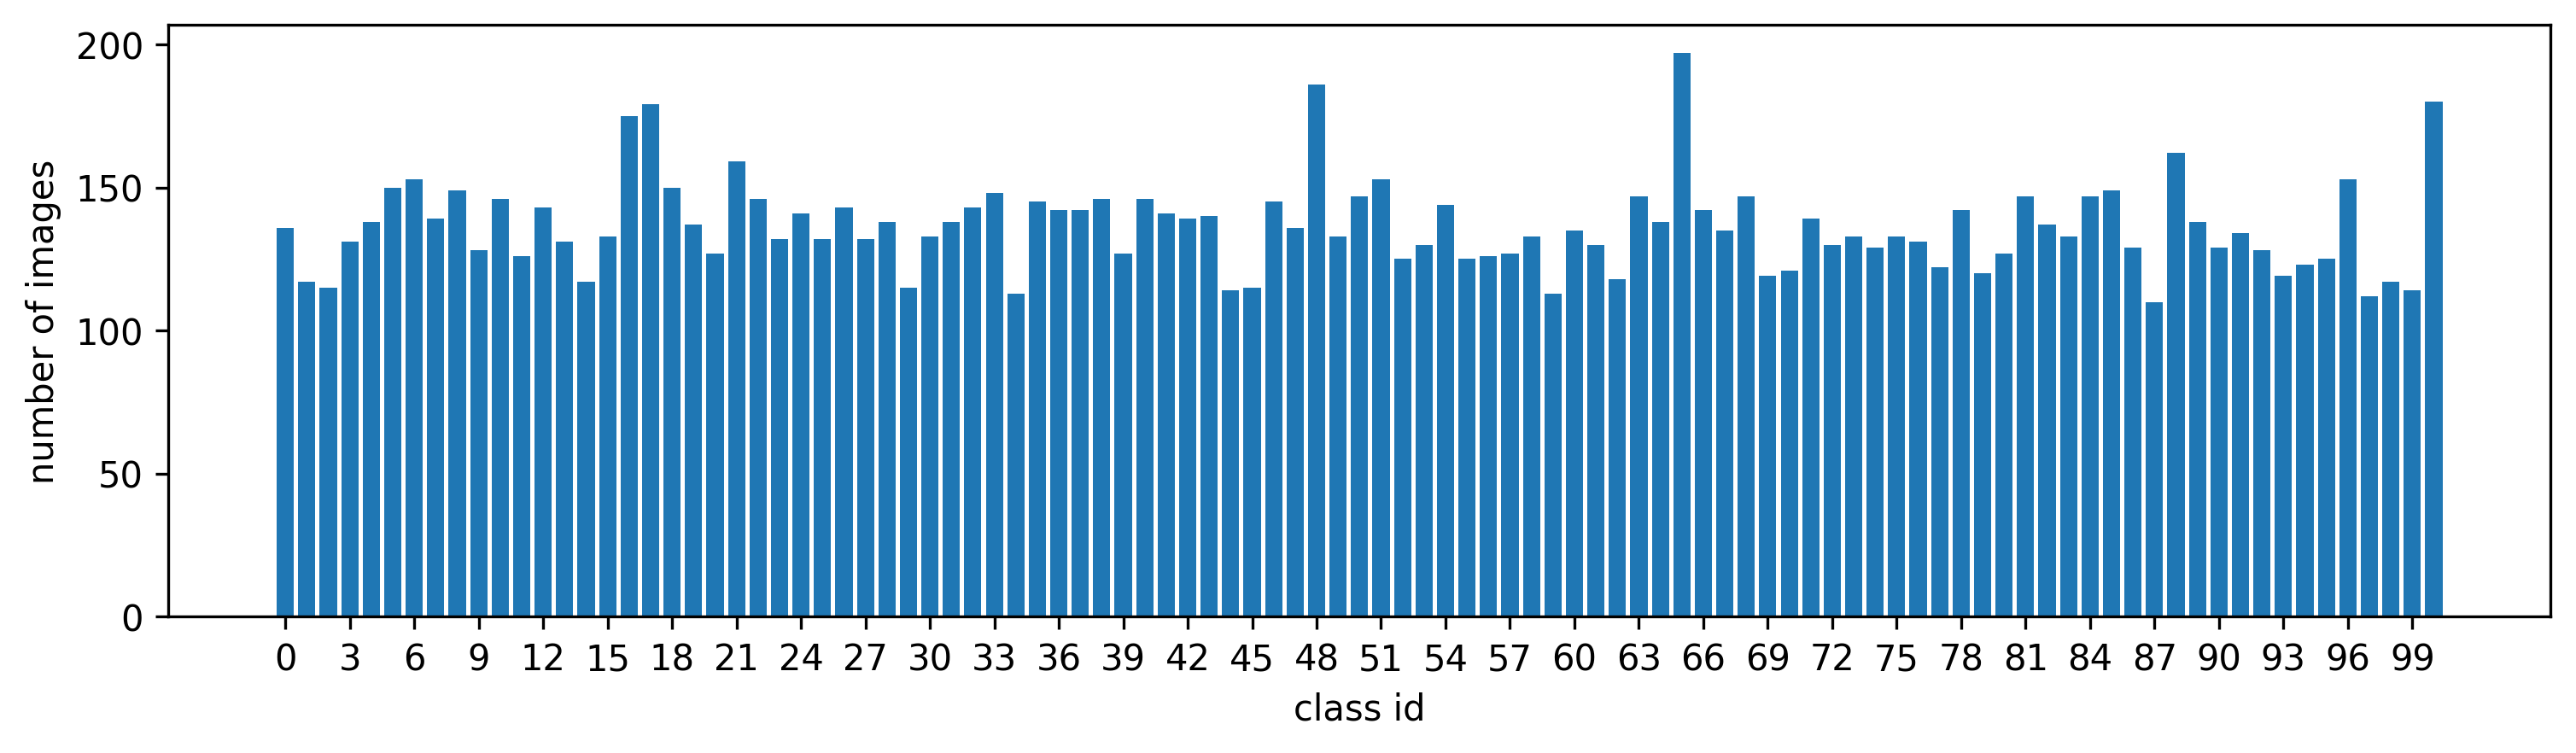

In [45]:
plt.figure(figsize=(12, 3), dpi=300)
bars = df_full.groupby('class id').count()['labels'].tolist()
plt.bar(range(0, 101), bars)
plt.xticks(np.arange(0, 101, 3))
plt.xlabel('class id')
plt.ylabel('number of images')
plt.grid(False)
plt.show()

use the `class id` and `labels` columns to create a dictionary for easily converting one into the other.

model training uses class numbers from 0 to 99, however for visualizing and understanding the results a label is much clearer.

In [14]:
id2label = df_full[['class id', 'labels']].groupby('class id').first().to_dict()['labels']

In [15]:
import pickle
with open('id2label', 'wb') as f:
  pickle.dump(id2label, f)

finally, the dataset is split into 80% train, 10% validation and 10% testing.

In [16]:
df_train, df_split = train_test_split(df_full, test_size=0.2)
df_valid, df_test = train_test_split(df_split, test_size=0.5)

print(f'''the dataset contains:
{len(df_train)} training images
{len(df_valid)} validation images
{len(df_test)} testing images''')

the dataset contains:
11019 training images
1377 validation images
1378 testing images


a custom pytorch dataset class is defined to easily handle the fetching and preprocessing of images.

In [17]:
class ButterflyDataset(data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, root: str = 'data', transform = None) -> None:
        super().__init__()
        self.data = dataframe
        self.root = root
        self.T = transform

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        image_path, class_id = self.data.iloc[index][['filepaths', 'class id']]
        image_path = os.path.join(self.root, image_path)
        image = Image.open(image_path)
        if image.mode != 'RGB':
          image = image.convert(mode='RGB')
        image = self.T(image)

        return image, torch.tensor(class_id)

    def display(self, index=None, id=None):
        if id is not None:
          image_path = self.data[self.data['class id'] == id].sample(1).iloc[0]['filepaths']
          class_id = id
        elif index is not None:
          image_path, class_id = self.data.iloc[index][['filepaths', 'class id']]
        else:
          raise "speficy either index or class id"
        image_path = os.path.join(self.root, image_path)
        image = Image.open(image_path)

        plt.imshow(image, interpolation='none')
        plt.axis('off')
        plt.title(f'{id2label[class_id]}')
        plt.show()

define the preprocessing steps to apply to each image when training and when validating/testing.

In [25]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

create the dataset and dataloader objects.

In [20]:
ds_train = ButterflyDataset(df_train, transform=transform_train)
dl_train = data.DataLoader(ds_train, batch_size=8, shuffle=True, drop_last=True, num_workers=0)

ds_valid = ButterflyDataset(df_valid, transform=transform_valid)
dl_valid = data.DataLoader(ds_valid, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

ds_test = ButterflyDataset(df_test, transform=transform_valid)
dl_test = data.DataLoader(ds_test, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

visualize the geometric transformations applied during training.

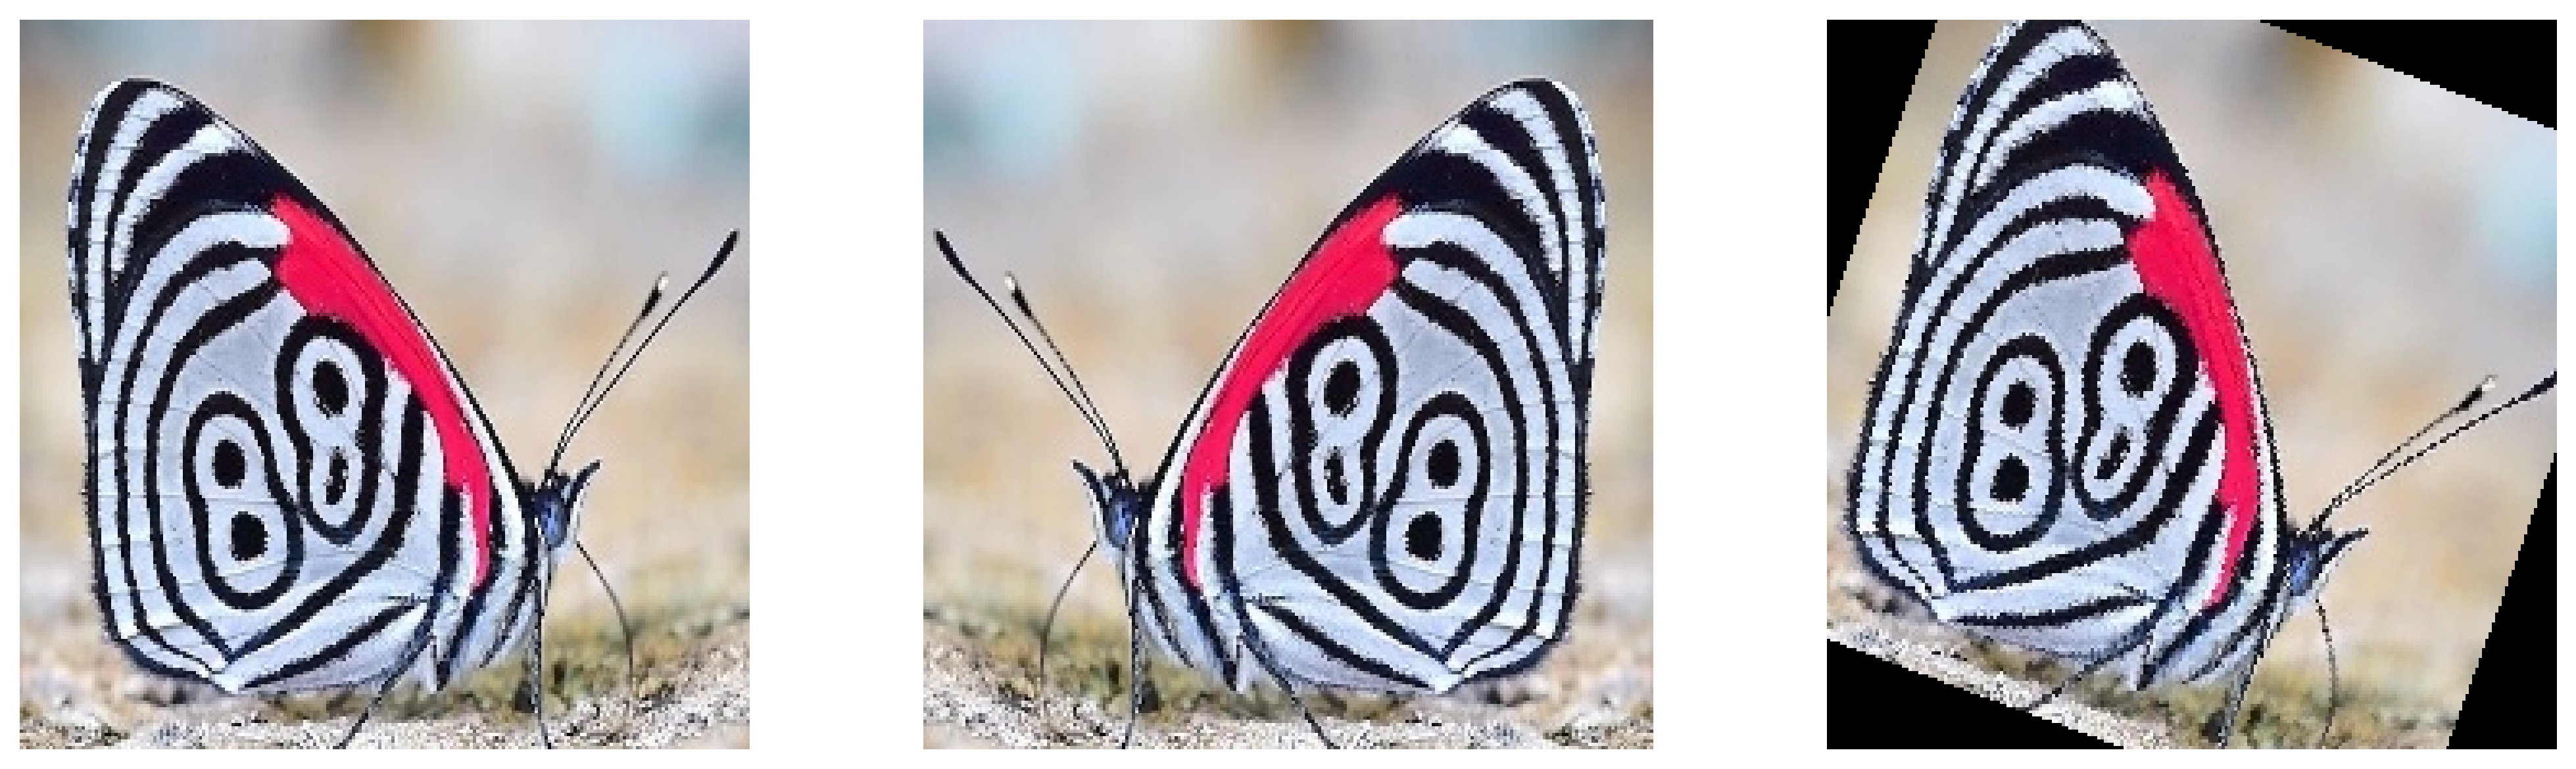

In [27]:
i = Image.open('data/train/AN 88/001.jpg')
plt.subplots(1, 3, figsize=(14, 4), dpi=300)
plt.subplot(131)
plt.imshow(i)
plt.axis('off')
plt.subplot(132)
plt.imshow(transforms.RandomHorizontalFlip(p=1.)(i))
plt.axis('off')
plt.subplot(133)
plt.imshow(transforms.RandomRotation(degrees=(-180, 180))(i))
plt.axis('off')
plt.tight_layout()
plt.show()

# training

In [22]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"training on {DEVICE.upper()}")

training on CUDA


train different variants of Swin Transformers, increasing in size.

In [37]:
metrics = {}

for model_class, model_weights, model_name in [
    (models.swin_t, models.Swin_T_Weights, 'swin-t'),
    (models.swin_s, models.Swin_S_Weights, 'swin-s'),
    (models.swin_b, models.Swin_B_Weights, 'swin-b')
]:
    # initialize model
    print(model_name.upper())
    model = model_class(weights=model_weights.DEFAULT)
    model.head = nn.Linear(model.head.in_features, 101)
    model.to(DEVICE)
    # initialize optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=1e-4)
    # initialize loss function
    criterion = nn.CrossEntropyLoss()
    # initialize performance metric
    run_start_time = datetime.now().isoformat()[:-7].replace(':','-').replace('T','_')
    accuracy = tm.Accuracy(task='multiclass', num_classes=101, average=None).to(DEVICE)
    best_accuracy = 0
    metrics[model_name] = {
        "accuracy_training": [],
        "accuracy_validation": [],
        "best_model_filename": "",
        "best_singleclass_accuracies": []
    }
    print(f'starting training at {run_start_time}')
    # start model training and evalutaion loop
    for epoch_index in range(5):
        print(f"---------------------\nEPOCH {epoch_index:02d}")
        # put model in training mode
        model.train()
        accuracy.reset()
        for input, ground_truth in tqdm(dl_train, desc="train"):
            # move tensors to same device as network
            input = input.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            # reset gradients
            optimizer.zero_grad()
            # do forward pass
            logits = model(input)
            accuracy.update(logits, ground_truth)
            # evaluate loss
            loss = criterion(logits, ground_truth)
            # do back-propagation
            loss.backward()
            # update network weights
            optimizer.step()
        # save training accuracy
        metrics[model_name]['accuracy_training'].append(accuracy.compute().mean().item())
        # put model in evaluation mode
        model.eval()
        with torch.no_grad():
            accuracy.reset()
            for input, ground_truth in tqdm(dl_valid, desc='valid'):
                # move tensors to same device as network
                input = input.to(DEVICE)
                ground_truth = ground_truth.to(DEVICE)
                # do forward pass
                logits = model(input)
                accuracy.update(logits, ground_truth)
            # calculate validation accuracy
            validation_accuracy = accuracy.compute().mean().item()
            # save validation accuracy
            metrics[model_name]['accuracy_validation'].append(validation_accuracy)
            print('accuracy', validation_accuracy)
            # check if a new best model has been found
            if validation_accuracy > best_accuracy:
                print("new best model found")
                # save model to file
                torch.save(model.state_dict(), f'{model_name}_state_dict_{run_start_time}.pth')
                #   !cp "{model_name}_state_dict_{run_start_time}.pth" '/content/gdrive/MyDrive/'
                # update the best accuracy
                best_accuracy = validation_accuracy
                metrics[model_name]['best_model_filename'] = f'{model_name}_state_dict_{run_start_time}.pth'
                metrics[model_name]['best_singleclass_accuracies'] = accuracy.compute().cpu()

with open('metrics-swin', 'wb') as f:
    pickle.dump(metrics, f)

SWIN-T
starting training at 2023-07-13_13-14-57
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [00:12<00:00,  3.47it/s]


accuracy 0.8799945116043091
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [00:12<00:00,  3.47it/s]


accuracy 0.904804527759552
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [00:12<00:00,  3.51it/s]


accuracy 0.9083067774772644
new best model found
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [00:12<00:00,  3.49it/s]


accuracy 0.8971450924873352
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [00:12<00:00,  3.49it/s]


accuracy 0.9087877869606018
new best model found
SWIN-S
starting training at 2023-07-13_13-35-24
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [00:18<00:00,  2.32it/s]


accuracy 0.8882935047149658
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [00:19<00:00,  2.31it/s]


accuracy 0.9112323522567749
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [00:18<00:00,  2.32it/s]


accuracy 0.9022665619850159
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [00:18<00:00,  2.33it/s]


accuracy 0.909622848033905
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [00:18<00:00,  2.34it/s]


accuracy 0.9187383055686951
new best model found
SWIN-B
starting training at 2023-07-13_14-10-20
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [03:13<00:00,  4.39s/it]


accuracy 0.9054093360900879
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [03:29<00:00,  4.76s/it]


accuracy 0.914590060710907
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [05:18<00:00,  7.25s/it]


accuracy 0.9055066704750061
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [04:07<00:00,  5.63s/it]


accuracy 0.9361242651939392
new best model found
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [02:00<00:00,  2.74s/it]

accuracy 0.9294182658195496


train different variants of ResNets, increasing in size.

In [23]:
metrics = {}

for model_class, model_weights, model_name in [
    (models.resnet18, models.ResNet18_Weights, 'resnet18'),
    (models.resnet50, models.ResNet50_Weights, 'resnet50'),
    (models.resnet152, models.ResNet152_Weights, 'resnet152')
]:
    # initialize model
    print(model_name.upper())
    model = model_class(weights=model_weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 101)
    model.to(DEVICE)
    # initialize optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=1e-4)
    # initialize loss function
    criterion = nn.CrossEntropyLoss()
    # initialize performance metric
    run_start_time = datetime.now().isoformat()[:-7].replace(':','-').replace('T','_')
    accuracy = tm.Accuracy(task='multiclass', num_classes=101, average=None).to(DEVICE)
    best_accuracy = 0
    metrics[model_name] = {
        "accuracy_training": [],
        "accuracy_validation": [],
        "best_model_filename": "",
        "best_singleclass_accuracies": []
    }
    print(f'starting training at {run_start_time}')
    # start model training and evalutaion loop
    for epoch_index in range(10):
        print(f"---------------------\nEPOCH {epoch_index:02d}")
        # put model in training mode
        model.train()
        accuracy.reset()
        for input, ground_truth in tqdm(dl_train, desc="train"):
            # move tensors to same device as network
            input = input.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            # reset gradients
            optimizer.zero_grad()
            # do forward pass
            logits = model(input)
            accuracy.update(logits, ground_truth)
            # evaluate loss
            loss = criterion(logits, ground_truth)
            # do back-propagation
            loss.backward()
            # update network weights
            optimizer.step()
        # save training accuracy
        metrics[model_name]['accuracy_training'].append(accuracy.compute().mean().item())
        # put model in evaluation mode
        model.eval()
        with torch.no_grad():
            accuracy.reset()
            for input, ground_truth in tqdm(dl_valid, desc='valid'):
                # move tensors to same device as network
                input = input.to(DEVICE)
                ground_truth = ground_truth.to(DEVICE)
                # do forward pass
                logits = model(input)
                accuracy.update(logits, ground_truth)
            # calculate validation accuracy
            validation_accuracy = accuracy.compute().mean().item()
            # save validation accuracy
            metrics[model_name]['accuracy_validation'].append(validation_accuracy)
            print('accuracy', validation_accuracy)
            # check if a new best model has been found
            if validation_accuracy > best_accuracy:
                print("new best model found")
                # save model to file
                torch.save(model.state_dict(), f'{model_name}_state_dict_{run_start_time}.pth')
                # !cp "{model_name}_state_dict_{run_start_time}.pth" '/content/gdrive/MyDrive/'
                # update the best accuracy
                best_accuracy = validation_accuracy
                metrics[model_name]['best_model_filename'] = f'{model_name}_state_dict_{run_start_time}.pth'
                metrics[model_name]['best_singleclass_accuracies'] = accuracy.compute().cpu()

with open('metrics-resnet', 'wb') as f:
    pickle.dump(metrics, f)

RESNET18
starting training at 2023-07-14_08-53-02
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [00:05<00:00,  7.69it/s]


accuracy 0.8853039145469666
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [00:05<00:00,  8.65it/s]


accuracy 0.8967368006706238
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [00:04<00:00,  9.38it/s]


accuracy 0.9144380688667297
new best model found
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [00:04<00:00,  9.01it/s]


accuracy 0.9211729168891907
new best model found
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [00:05<00:00,  8.59it/s]


accuracy 0.9138683676719666
---------------------
EPOCH 05


valid: 100%|██████████| 44/44 [00:05<00:00,  8.02it/s]


accuracy 0.9272815585136414
new best model found
---------------------
EPOCH 06


valid: 100%|██████████| 44/44 [00:05<00:00,  8.25it/s]


accuracy 0.9292860627174377
new best model found
---------------------
EPOCH 07


valid: 100%|██████████| 44/44 [00:04<00:00,  9.00it/s]


accuracy 0.9321062564849854
new best model found
---------------------
EPOCH 08


valid: 100%|██████████| 44/44 [00:05<00:00,  8.11it/s]


accuracy 0.9220182299613953
---------------------
EPOCH 09


valid: 100%|██████████| 44/44 [00:04<00:00,  9.00it/s]


accuracy 0.9204968810081482
RESNET50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Alberto/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s] 


starting training at 2023-07-14_09-13-37
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s]


accuracy 0.8687352538108826
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [00:09<00:00,  4.77it/s]


accuracy 0.8941065669059753
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s]


accuracy 0.9062217473983765
new best model found
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s]


accuracy 0.9062137007713318
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s]


accuracy 0.9288207292556763
new best model found
---------------------
EPOCH 05


valid: 100%|██████████| 44/44 [00:09<00:00,  4.78it/s]


accuracy 0.9199040532112122
---------------------
EPOCH 06


valid: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s]


accuracy 0.9290658235549927
new best model found
---------------------
EPOCH 07


valid: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s]


accuracy 0.918354332447052
---------------------
EPOCH 08


valid: 100%|██████████| 44/44 [00:09<00:00,  4.76it/s]


accuracy 0.9192856550216675
---------------------
EPOCH 09


valid: 100%|██████████| 44/44 [00:08<00:00,  5.36it/s]


accuracy 0.9301683902740479
new best model found
RESNET152


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\Alberto/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 77.3MB/s] 


starting training at 2023-07-14_09-47-59
---------------------
EPOCH 00


valid: 100%|██████████| 44/44 [00:15<00:00,  2.88it/s]


accuracy 0.8584670424461365
new best model found
---------------------
EPOCH 01


valid: 100%|██████████| 44/44 [00:15<00:00,  2.90it/s]


accuracy 0.875766396522522
new best model found
---------------------
EPOCH 02


valid: 100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


accuracy 0.8819643259048462
new best model found
---------------------
EPOCH 03


valid: 100%|██████████| 44/44 [00:15<00:00,  2.88it/s]


accuracy 0.9042757153511047
new best model found
---------------------
EPOCH 04


valid: 100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


accuracy 0.9064046740531921
new best model found
---------------------
EPOCH 05


valid: 100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


accuracy 0.907177746295929
new best model found
---------------------
EPOCH 06


valid: 100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


accuracy 0.9030711650848389
---------------------
EPOCH 07


valid: 100%|██████████| 44/44 [00:18<00:00,  2.43it/s]


accuracy 0.9170557260513306
new best model found
---------------------
EPOCH 08


valid: 100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


accuracy 0.9209041595458984
new best model found
---------------------
EPOCH 09


valid: 100%|██████████| 44/44 [00:16<00:00,  2.66it/s]

accuracy 0.9188714027404785


# comparing models

In [62]:
with open('metrics-swin', 'rb') as f:
    metrics_swin = pickle.load(f)
with open('metrics-resnet', 'rb') as f:
    metrics_resnet = pickle.load(f)

define a function to measure the inference speed of a given model by forwarding 50 dummy images.

In [73]:
def measure_inference_speed(model):
    NUM_DUMMY_IMAGES = 50
    dummy_input = torch.randn((NUM_DUMMY_IMAGES, 224, 224, 3)).numpy()
    model.eval()
    with torch.no_grad():
        with profile(activities=[ProfilerActivity.CPU], record_shapes=False) as prof:
            for image in dummy_input:
                with record_function('model_inference'):
                    image = transform_valid(image)
                    _ = model(image.unsqueeze(0))

    for i in prof.key_averages():
        if i.key == 'model_inference':
            info = i
            break

    speed = info.cpu_time_total/info.count/1000

    return speed

compare all the trained models by looking at their inference speed with respect to their accuracy

100%|██████████| 3/3 [00:53<00:00, 17.86s/it]


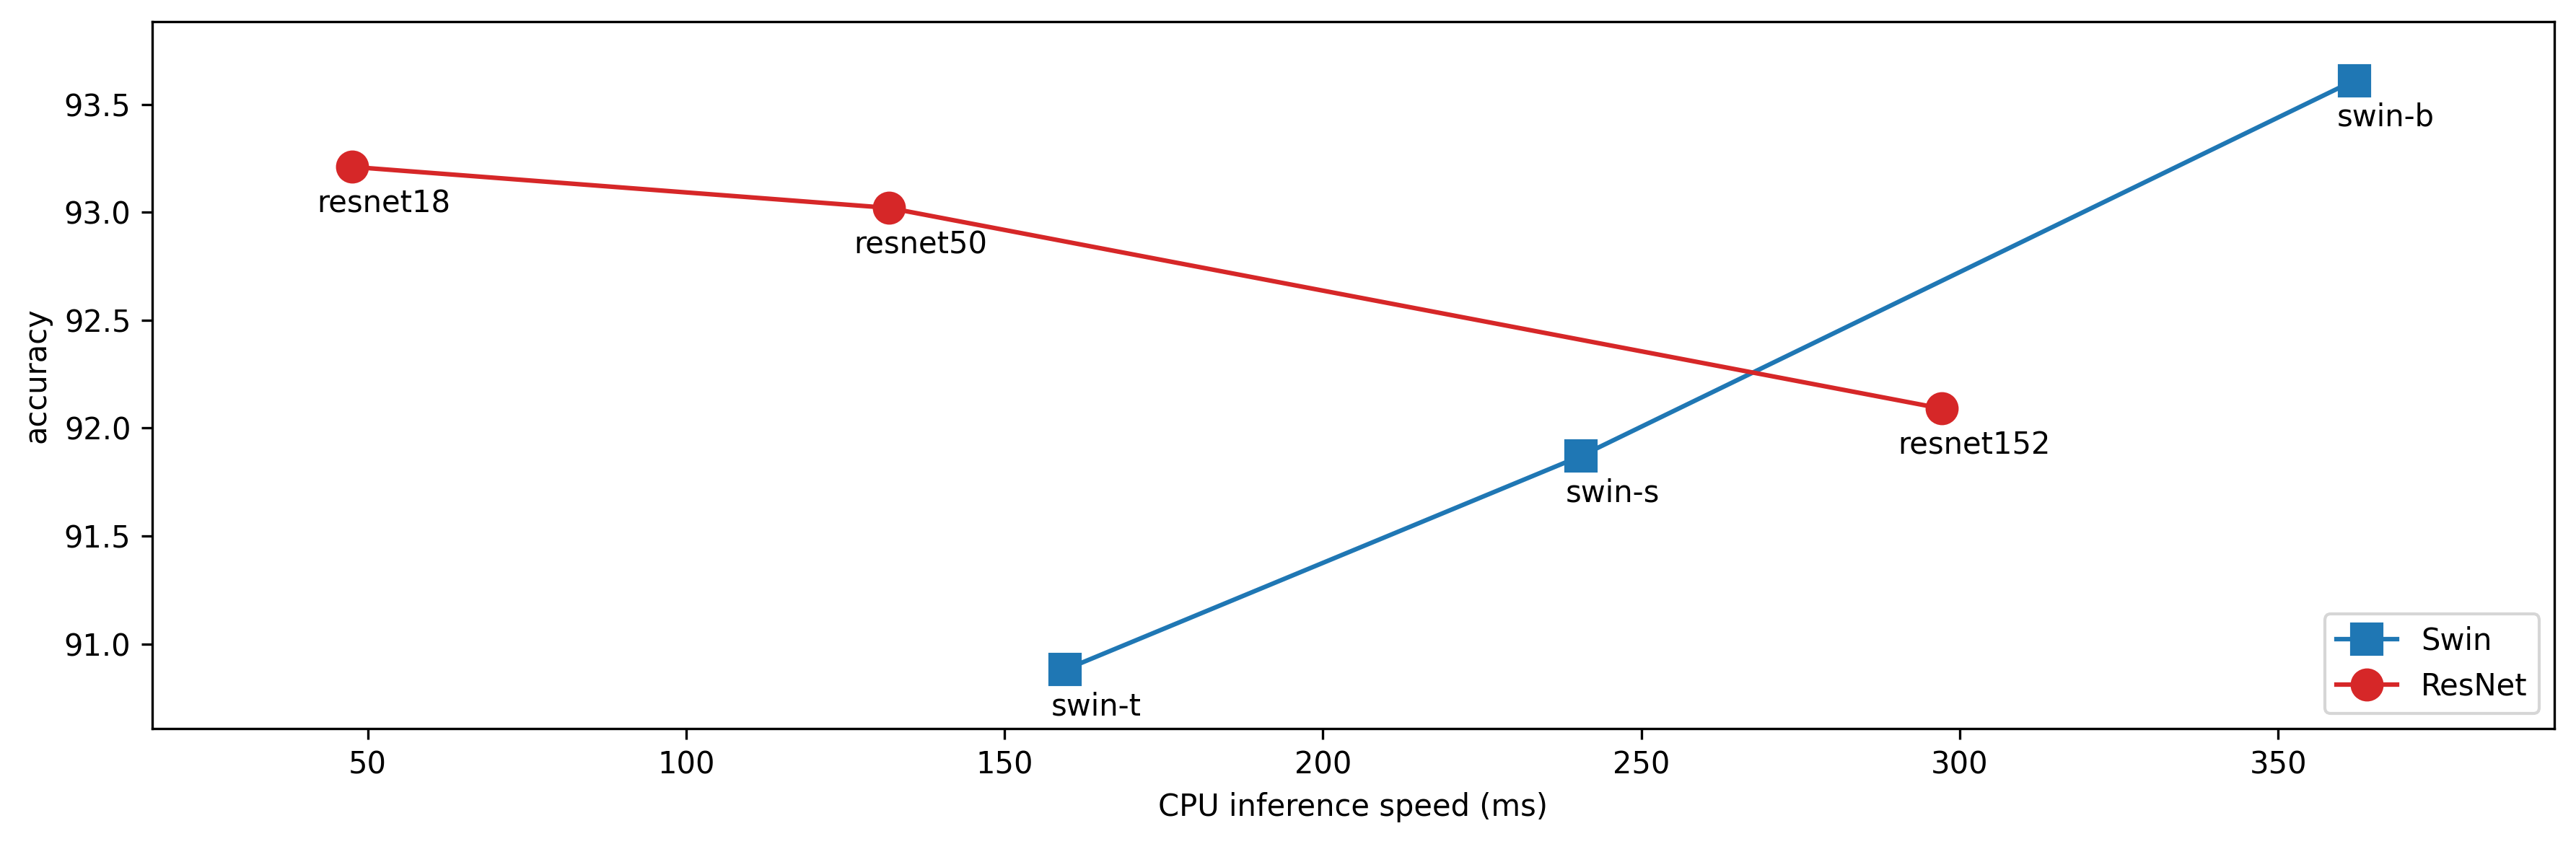

In [175]:
plt.figure(figsize=(12, 4), dpi=300)

for family in [
    [
        (models.swin_t, models.Swin_T_Weights, 'swin-t'),
        (models.swin_s, models.Swin_S_Weights, 'swin-s'),
        (models.swin_b, models.Swin_B_Weights, 'swin-b')
    ],
    [
        (models.resnet18, models.ResNet18_Weights, 'resnet18'),
        (models.resnet50, models.ResNet50_Weights, 'resnet50'),
        (models.resnet152, models.ResNet152_Weights, 'resnet152')
    ]
]:
    speeds, accuracies, names = [], [], []
    for model_class, model_weights, model_name in tqdm(family):

        model = model_class(weights=model_weights.DEFAULT)

        if model_name.startswith('swin'):
            model.head = nn.Linear(model.head.in_features, 101)
            metrics = metrics_swin
            family_name = 'Swin'
            points_marker = 's'
            plot_color = 'C0'
        else:
            model.fc = nn.Linear(model.fc.in_features, 101)
            metrics = metrics_resnet
            family_name = 'ResNet'
            points_marker = 'o'
            plot_color = 'C3'

        fn = metrics[model_name]['best_model_filename']
        model.load_state_dict(torch.load(fn, map_location='cpu'))

        speed = measure_inference_speed(model)

        accuracy = round(100*metrics[model_name]['best_singleclass_accuracies'].numpy().mean(), 2)

        plt.text(speed+5, accuracy-.1, model_name, ha='center', va='top')
        
        names.append(model_name)
        speeds.append(speed)
        accuracies.append(accuracy)

    plt.plot(speeds, accuracies, c=plot_color, marker=points_marker, markersize=10, label=family_name)

plt.xlabel('CPU inference speed (ms)')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.margins(.1)
plt.show()

# testing

by the analysis above the best model for this project is ResNet18, therefore we run a final performance evaluation on the test set.

In [147]:
# initialize model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 101)
model.load_state_dict(torch.load(metrics_resnet['resnet18']['best_model_filename']))
model.to(DEVICE)
# initialize performance metric
accuracy = tm.Accuracy(task='multiclass', num_classes=101, average=None).to(DEVICE)
confusion_matrix = tm.ConfusionMatrix(task='multiclass', num_classes=101).to(DEVICE)
precision = tm.Precision(task='multiclass', num_classes=101).to(DEVICE)
recall = tm.Recall(task='multiclass', num_classes=101).to(DEVICE)
# put model in evaluation mode
model.eval()
with torch.no_grad():
    accuracy.reset()
    for input, ground_truth in tqdm(dl_test, desc='test'):
        # move tensors to same device as network
        input = input.to(DEVICE)
        ground_truth = ground_truth.to(DEVICE)
        # do forward pass
        logits = model(input)
        accuracy.update(logits, ground_truth)
        confusion_matrix.update(logits, ground_truth)
        precision.update(logits, ground_truth)
        recall.update(logits, ground_truth)
    # calculate validation accuracy
    testing_accuracies = accuracy.compute().cpu().numpy()*100
    print('accuracy', testing_accuracies.mean())
    print('precision', precision.compute().item())
    print('recall', recall.compute().item())

test: 100%|██████████| 44/44 [00:05<00:00,  7.56it/s]

accuracy 93.022026
precision 0.9325109124183655
recall 0.9325109124183655


visualize the accuracies of all the classes.

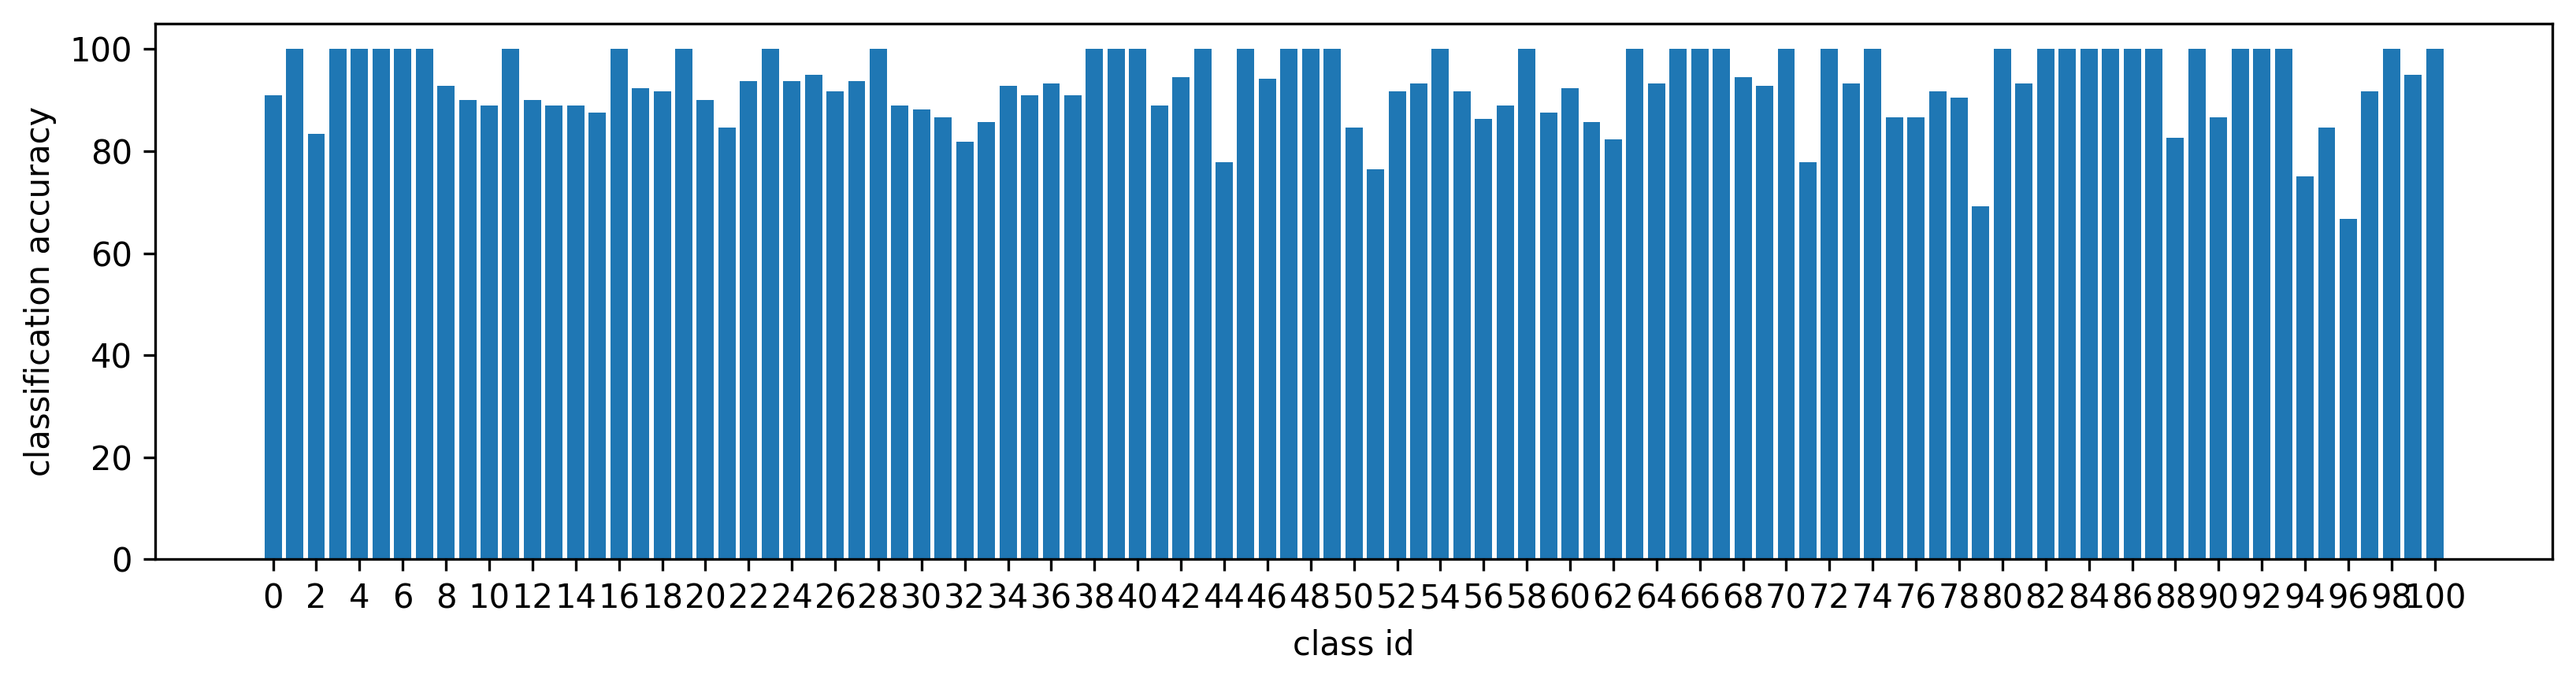

In [128]:
plt.figure(figsize=(11, 3), dpi=300)
plt.bar(range(101), testing_accuracies)
plt.xticks(range(0,101,2))
plt.xlabel('class id')
plt.ylabel('classification accuracy')
plt.tight_layout()
plt.show()

display also the confusion matrix.

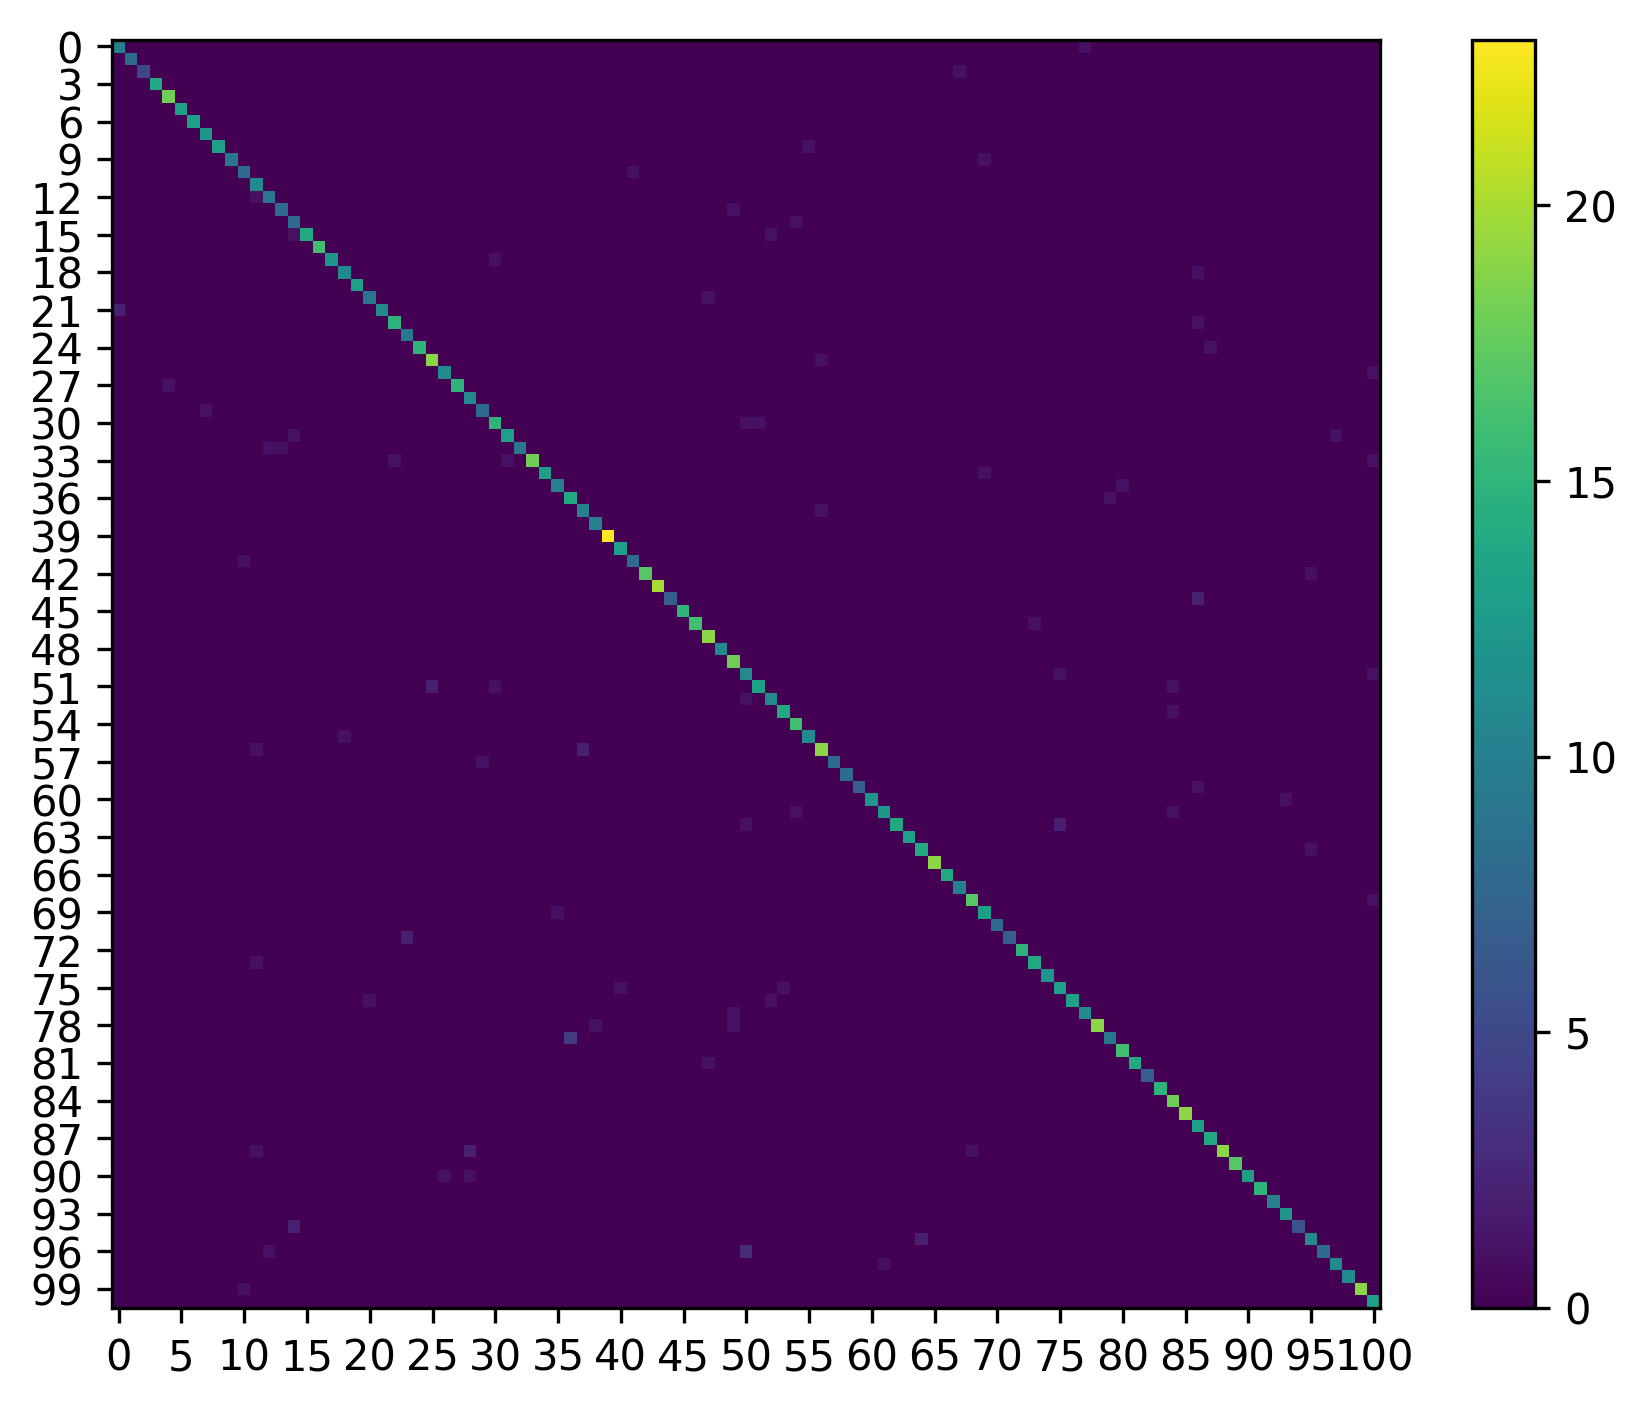

In [144]:
plt.figure(dpi=300)
plt.imshow(confusion_matrix.compute().cpu().numpy(), interpolation='none')
plt.xticks(range(0, 101, 5))
plt.yticks(range(0, 101, 3))
plt.colorbar()
plt.tight_layout()
plt.show()